In [20]:
# Modell laden (wenn noch nicht geschehen)
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model(r"C:\Users\berkb\Desktop\Uni\Bachelor\Projekt\Scenario A1-ARFF\Scenario A1-ARFF\KerasAE")

# Vorhersage und MSE
X_pred = model.predict(X_seq)
mse = np.mean(np.square(X_seq - X_pred), axis=(1, 2))  # für 3D-Input

16/16 [==============================] - 0s 3ms/step


X_seq shape: (3744, 288, 1)
117/117 [==============================] - 0s 2ms/step
Beispielhafte MSE: [4.9191422 3.1599085 3.5761566 3.2281358 4.2239013 3.3237867 3.7321913
 2.6741028 3.4928281 2.6800292]
Threshold (95%): 4.919142
Anomalien erkannt: 182 von 3744

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.92      0.98      0.94      3341
    Anomalie       0.55      0.25      0.35       403

    accuracy                           0.90      3744
   macro avg       0.74      0.61      0.64      3744
weighted avg       0.88      0.90      0.88      3744

CONFUSION MATRIX:
[[3260   81]
 [ 302  101]]


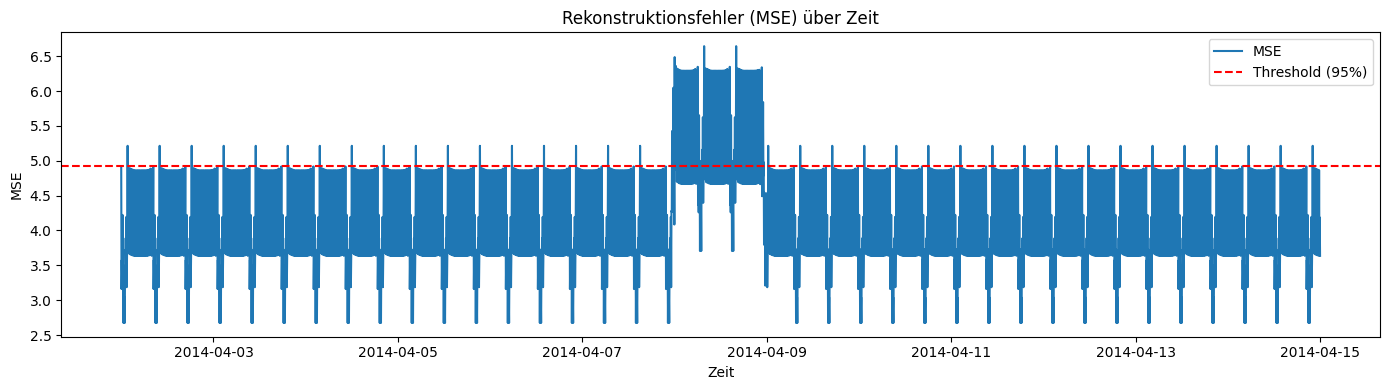

In [23]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras

# === 1. Pfade ===
csv_path = r"C:\Users\berkb\Desktop\Uni\Bachelor\Projekt\Scenario A1-ARFF\Scenario A1-ARFF\NAB\artificialWithAnomaly\artificialWithAnomaly\art_increase_spike_density.csv"
json_path = r"C:\Users\berkb\Desktop\Uni\Bachelor\Projekt\Scenario A1-ARFF\Scenario A1-ARFF\NAB\artificialWithAnomaly\artificialWithAnomaly\combined_windows.json"
model_path = r"C:\Users\berkb\Desktop\Uni\Bachelor\Projekt\Scenario A1-ARFF\Scenario A1-ARFF\KerasAE"

# === 2. Modell laden ===
model = keras.models.load_model(model_path)

# === 3. CSV einlesen und vorbereiten ===
df = pd.read_csv(csv_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
data = df['value'].values.astype(np.float32)

# === 4. Sequenzen erstellen ===
sequence_length = 288
X_seq = []
for i in range(len(data) - sequence_length):
    seq = data[i:i+sequence_length].reshape(-1, 1)  # (288, 1)
    X_seq.append(seq)
X_seq = np.array(X_seq)  # (n, 288, 1)
print("X_seq shape:", X_seq.shape)

# === 5. Vorhersage und MSE berechnen ===
pred = model.predict(X_seq)
mse = np.mean((X_seq - pred)**2, axis=(1, 2))
print("Beispielhafte MSE:", mse[:10])

# === 6. Threshold & Anomalien ===
threshold = np.percentile(mse, 95)
y_pred = (mse > threshold).astype(int)
print(f"Threshold (95%): {threshold:.6f}")
print(f"Anomalien erkannt: {np.sum(y_pred)} von {len(y_pred)}")

# === 7. Ground Truth aus JSON laden ===
with open(json_path, 'r') as f:
    gt = json.load(f)
filename = os.path.basename(csv_path)
windows = gt["artificialWithAnomaly/" + filename]

# === 8. Ground-Truth-Label erzeugen ===
timestamps = df.index[sequence_length:]
y_true = []
for ts in timestamps:
    is_anomaly = 0
    for start, end in windows:
        if pd.to_datetime(start) <= ts <= pd.to_datetime(end):
            is_anomaly = 1
            break
    y_true.append(is_anomaly)
y_true = np.array(y_true)

# === 9. Evaluation ===
print("\n📊 CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))
print("CONFUSION MATRIX:")
print(confusion_matrix(y_true, y_pred))

# === 10. Plot MSE mit Threshold ===
plt.figure(figsize=(14, 4))
plt.plot(timestamps, mse, label="MSE")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold (95%)")
plt.title("Rekonstruktionsfehler (MSE) über Zeit")
plt.xlabel("Zeit")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = [[3260, 81], [302, 101]]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalie'], yticklabels=['Normal', 'Anomalie'])
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächlich')
plt.title('Confusion Matrix des vortrainierten Modells')
plt.show()


ModuleNotFoundError: No module named 'seaborn'